In [152]:
%%shell
sudo add-apt-repository ppa:ubuntugis/ppa && sudo apt-get update
sudo apt-get update
pip install --upgrade geopandas

 Official stable UbuntuGIS packages.


 More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:13 http://pp

In [0]:
from google.colab import files
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import io

In [3]:
uploaded = files.upload()

Saving 10000-locations.csv to 10000-locations.csv


In [0]:
#GLOBAL VARIABLES
BUCKET_SIZE = 1000
ORIGIN_LATITUDE = 33613.1588
ORIGIN_LONGITUDE = -86118.3061
SOURCE_FILE_NAME = '10000-locations.csv'
OUTPUT_FILE = 'output-locations.xml'

Origin: POINT (33613.1588 -86118.3061)
Closest Customer: POINT (33596.7704 -86101.0833)


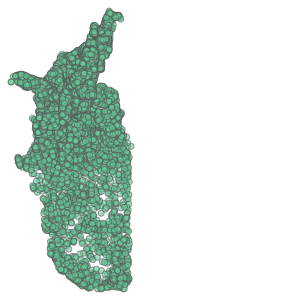

In [157]:
#Find the closest customer to origin
df = pd.read_csv(io.BytesIO(uploaded[SOURCE_FILE_NAME]), skiprows=[1])
df.set_index("id", inplace = True)
origin = Point(ORIGIN_LATITUDE, ORIGIN_LONGITUDE)
customers = MultiPoint([Point(xy) for xy in zip(df.latitude, df.longitude)])
nearest_geoms = nearest_points(origin, customers)
destination_closest = nearest_geoms[1]
print("Origin: " + str(origin))
print("Closest Customer: " + str(destination_closest))
origin
customers

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


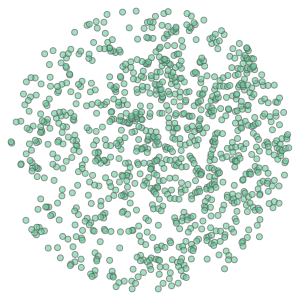

In [158]:
#Find the closest customers (quantity based on BUCKET_SIZE)
def create_gdf(df, x="latitude", y="longitude"):
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]), crs={"init":"EPSG:4326"})

gdf = create_gdf(df)
output = gdf.distance(origin).nsmallest(BUCKET_SIZE)
output_id_and_geo = gdf.loc[output.index.tolist() , 'geometry' ]
MultiPoint([x for x in output_id_and_geo.geometry])

In [0]:
#Output to xml
def func(row):
    xml = ['<item>']
    for field in row.index:
        xml.append('  <field name="{0}">{1}</field>'.format(field, row[field]))
    xml.append('</item>')
    return '\n'.join(xml)

f = open(OUTPUT_FILE, "w")
f.write('\n'.join(gdf.loc[output.index,:].apply(func, axis=1)))
f.close()